In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from sklearn import metrics
import tabulate
import itertools
import umap
from importlib import reload
from scipy import stats
import matplotlib.image as mpimg
import goatools
from goatools.anno.gaf_reader import GafReader
import Bio.UniProt.GOA as GOA
import gget

# locals
import utils as ut
reload(ut)

<module 'utils' from '/home/cstansbu/git_repositories/spatial_transcriptomics/clustering/utils.py'>

In [2]:
choose = 50 # number of genes to consider

# load gene lists 
pandPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/panglaodb/pandb.tsv.gz"        
pandf = ut.read_panglaodb(pandPath)

controlList = [
    'Adipocytes',
    'B cells', 
    'Dendritic cells',
    'Macrophages',
    'Monocytes', 
    'NK cells',
    'T cells', 
]

allMarkers = pandf[pandf['cell type'].isin(controlList)]

mfList = []
for ctype in controlList:
    cf = allMarkers[allMarkers['cell type'] == ctype]
    cf = cf.sort_values(by='ubiquitousness index',
                        ascending=True)
    mfList.append(cf[['cell type', 'gene']].head(choose))


markerGenes = pd.concat(mfList, ignore_index=True)
print(pd.DataFrame(markerGenes['cell type'].value_counts()))
print()

                 cell type
Adipocytes              50
B cells                 50
Dendritic cells         50
Macrophages             50
Monocytes               50
NK cells                50
T cells                 50



In [3]:
# load cluster assignments
cdf = pd.read_csv("clusterAssignments.csv")
cid = {}

for key in cdf['key'].unique():
    t = cdf[cdf['key'] == key]
    cid[key] = t
    
print('done')

done


# Load saved data

In [4]:
dirPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/scanpy/"

adata = {}

for f in os.listdir(dirPath):
    
    if f.endswith('.h5ad'):
        key = f.split(".")[0]
        fullPath = f"{dirPath}{f}"
        data = sc.read(fullPath)
        adata[key] = data
    
print("done")

done


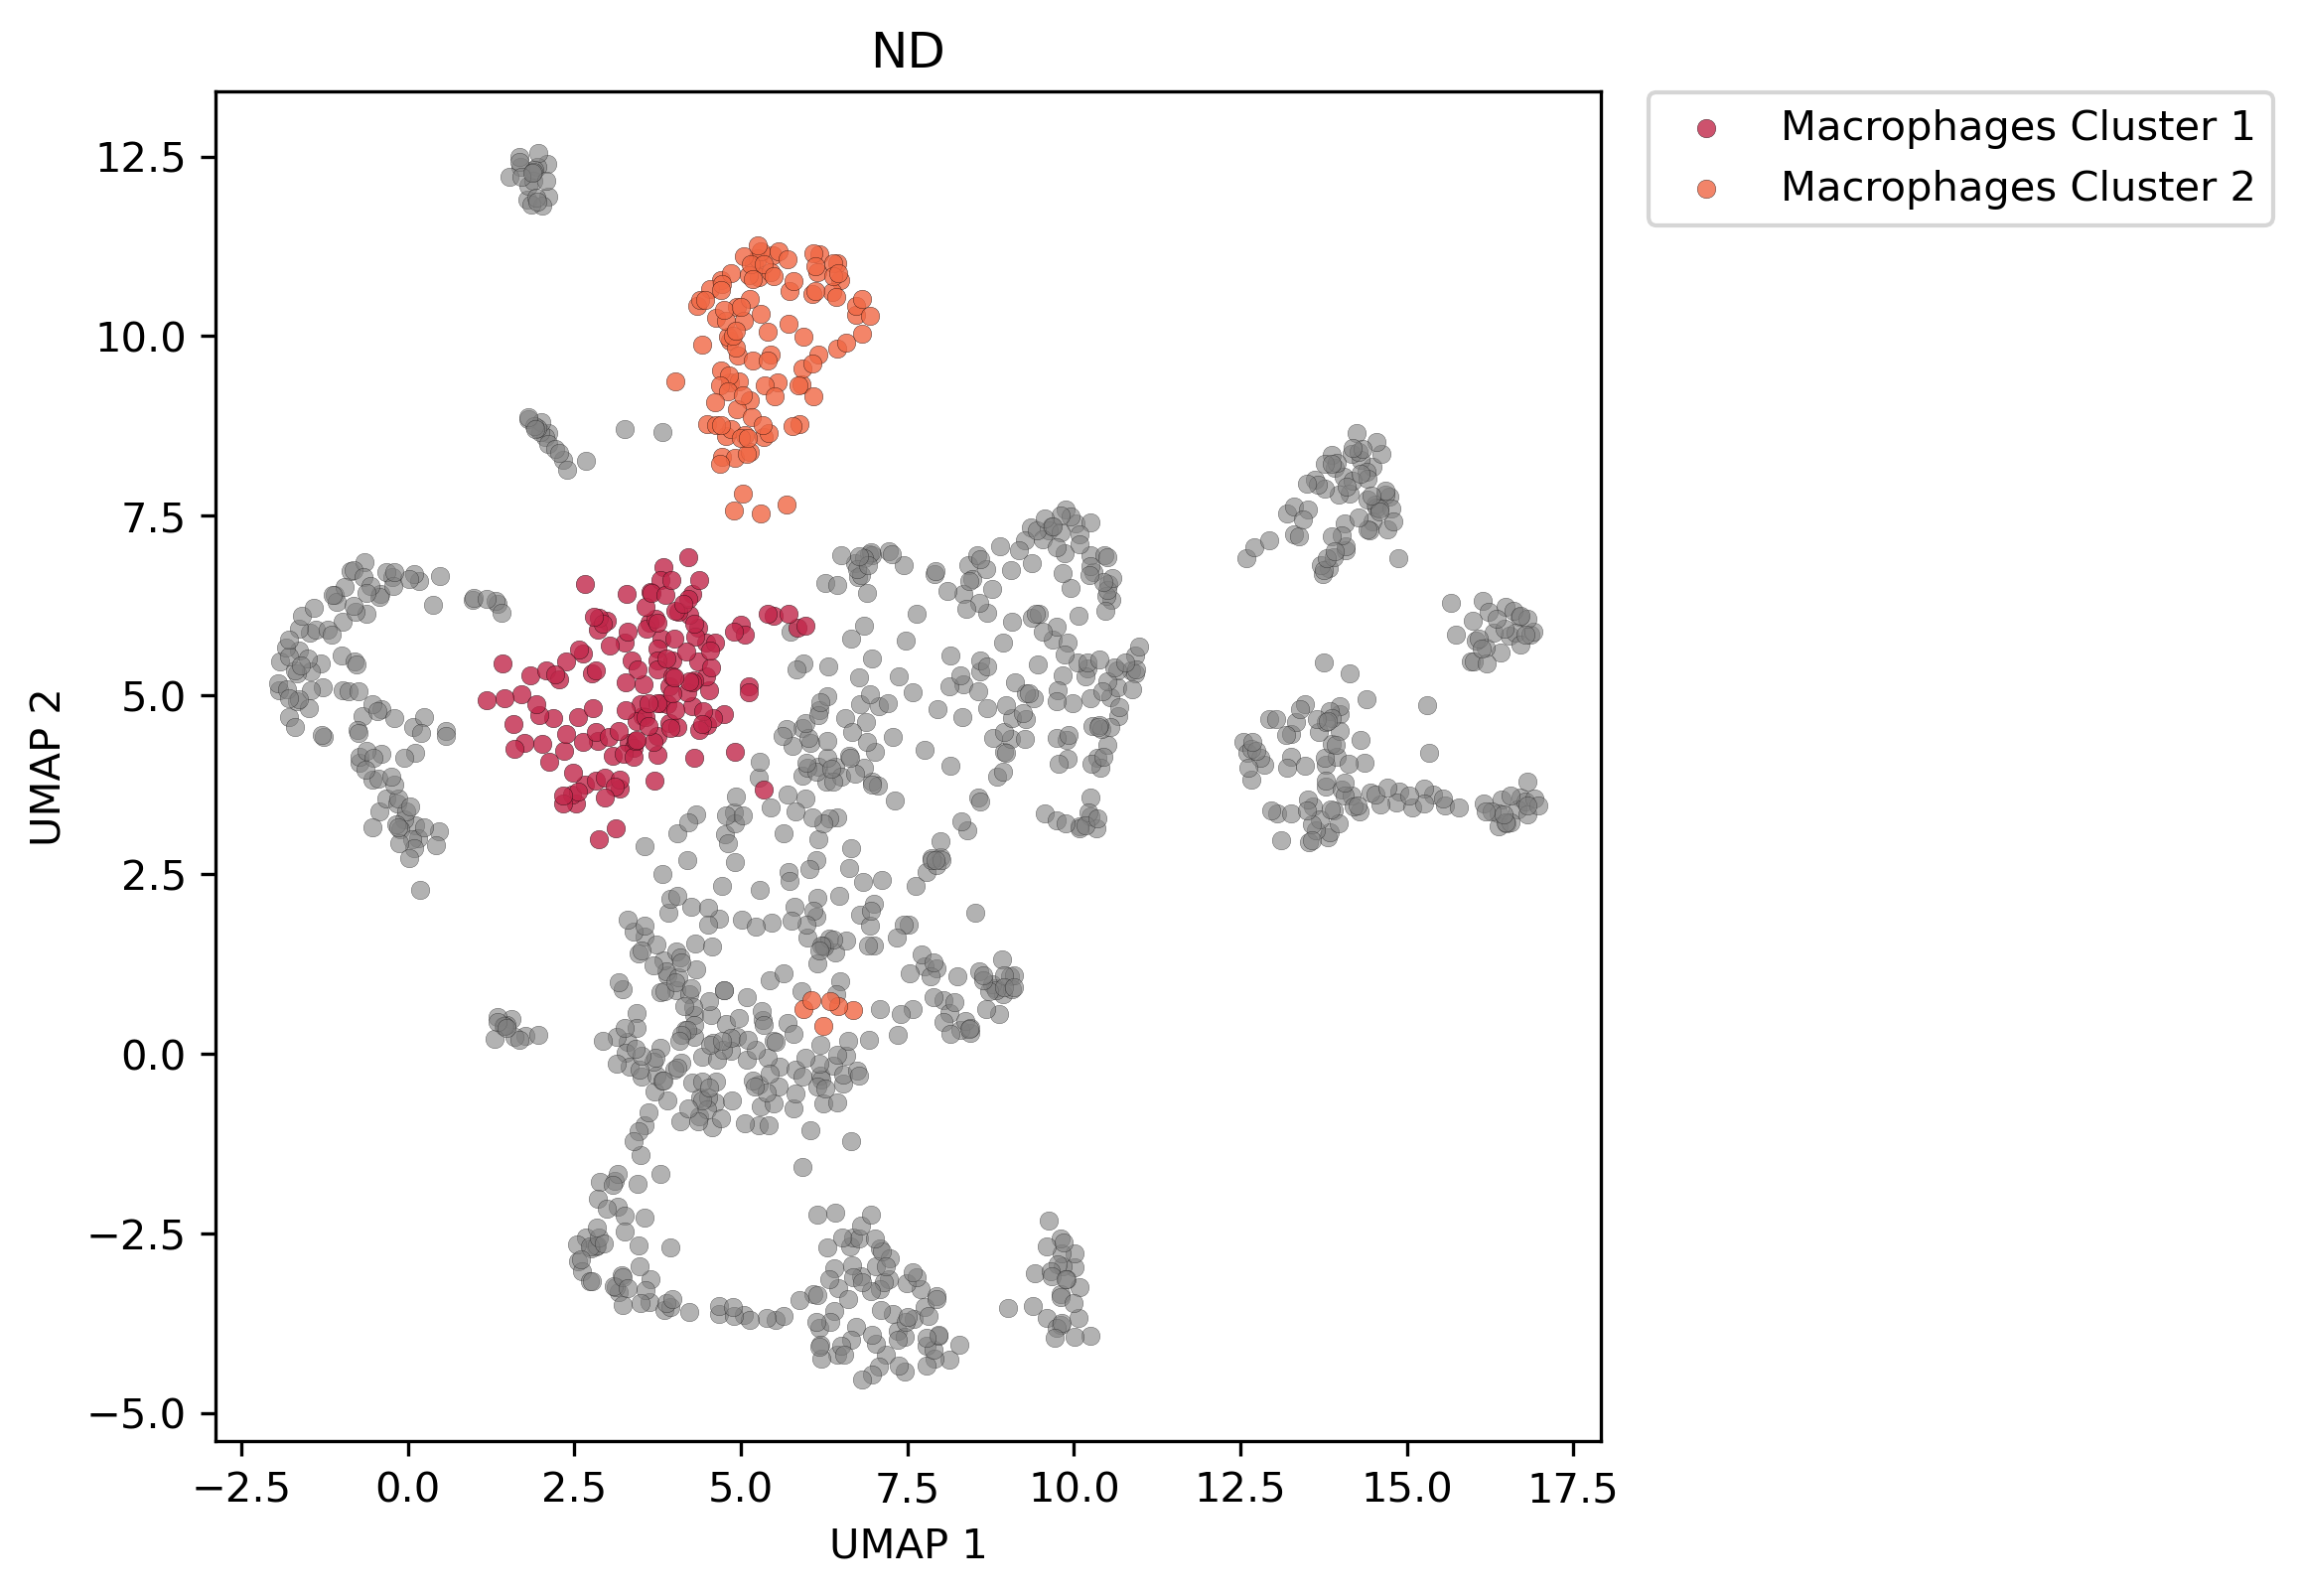

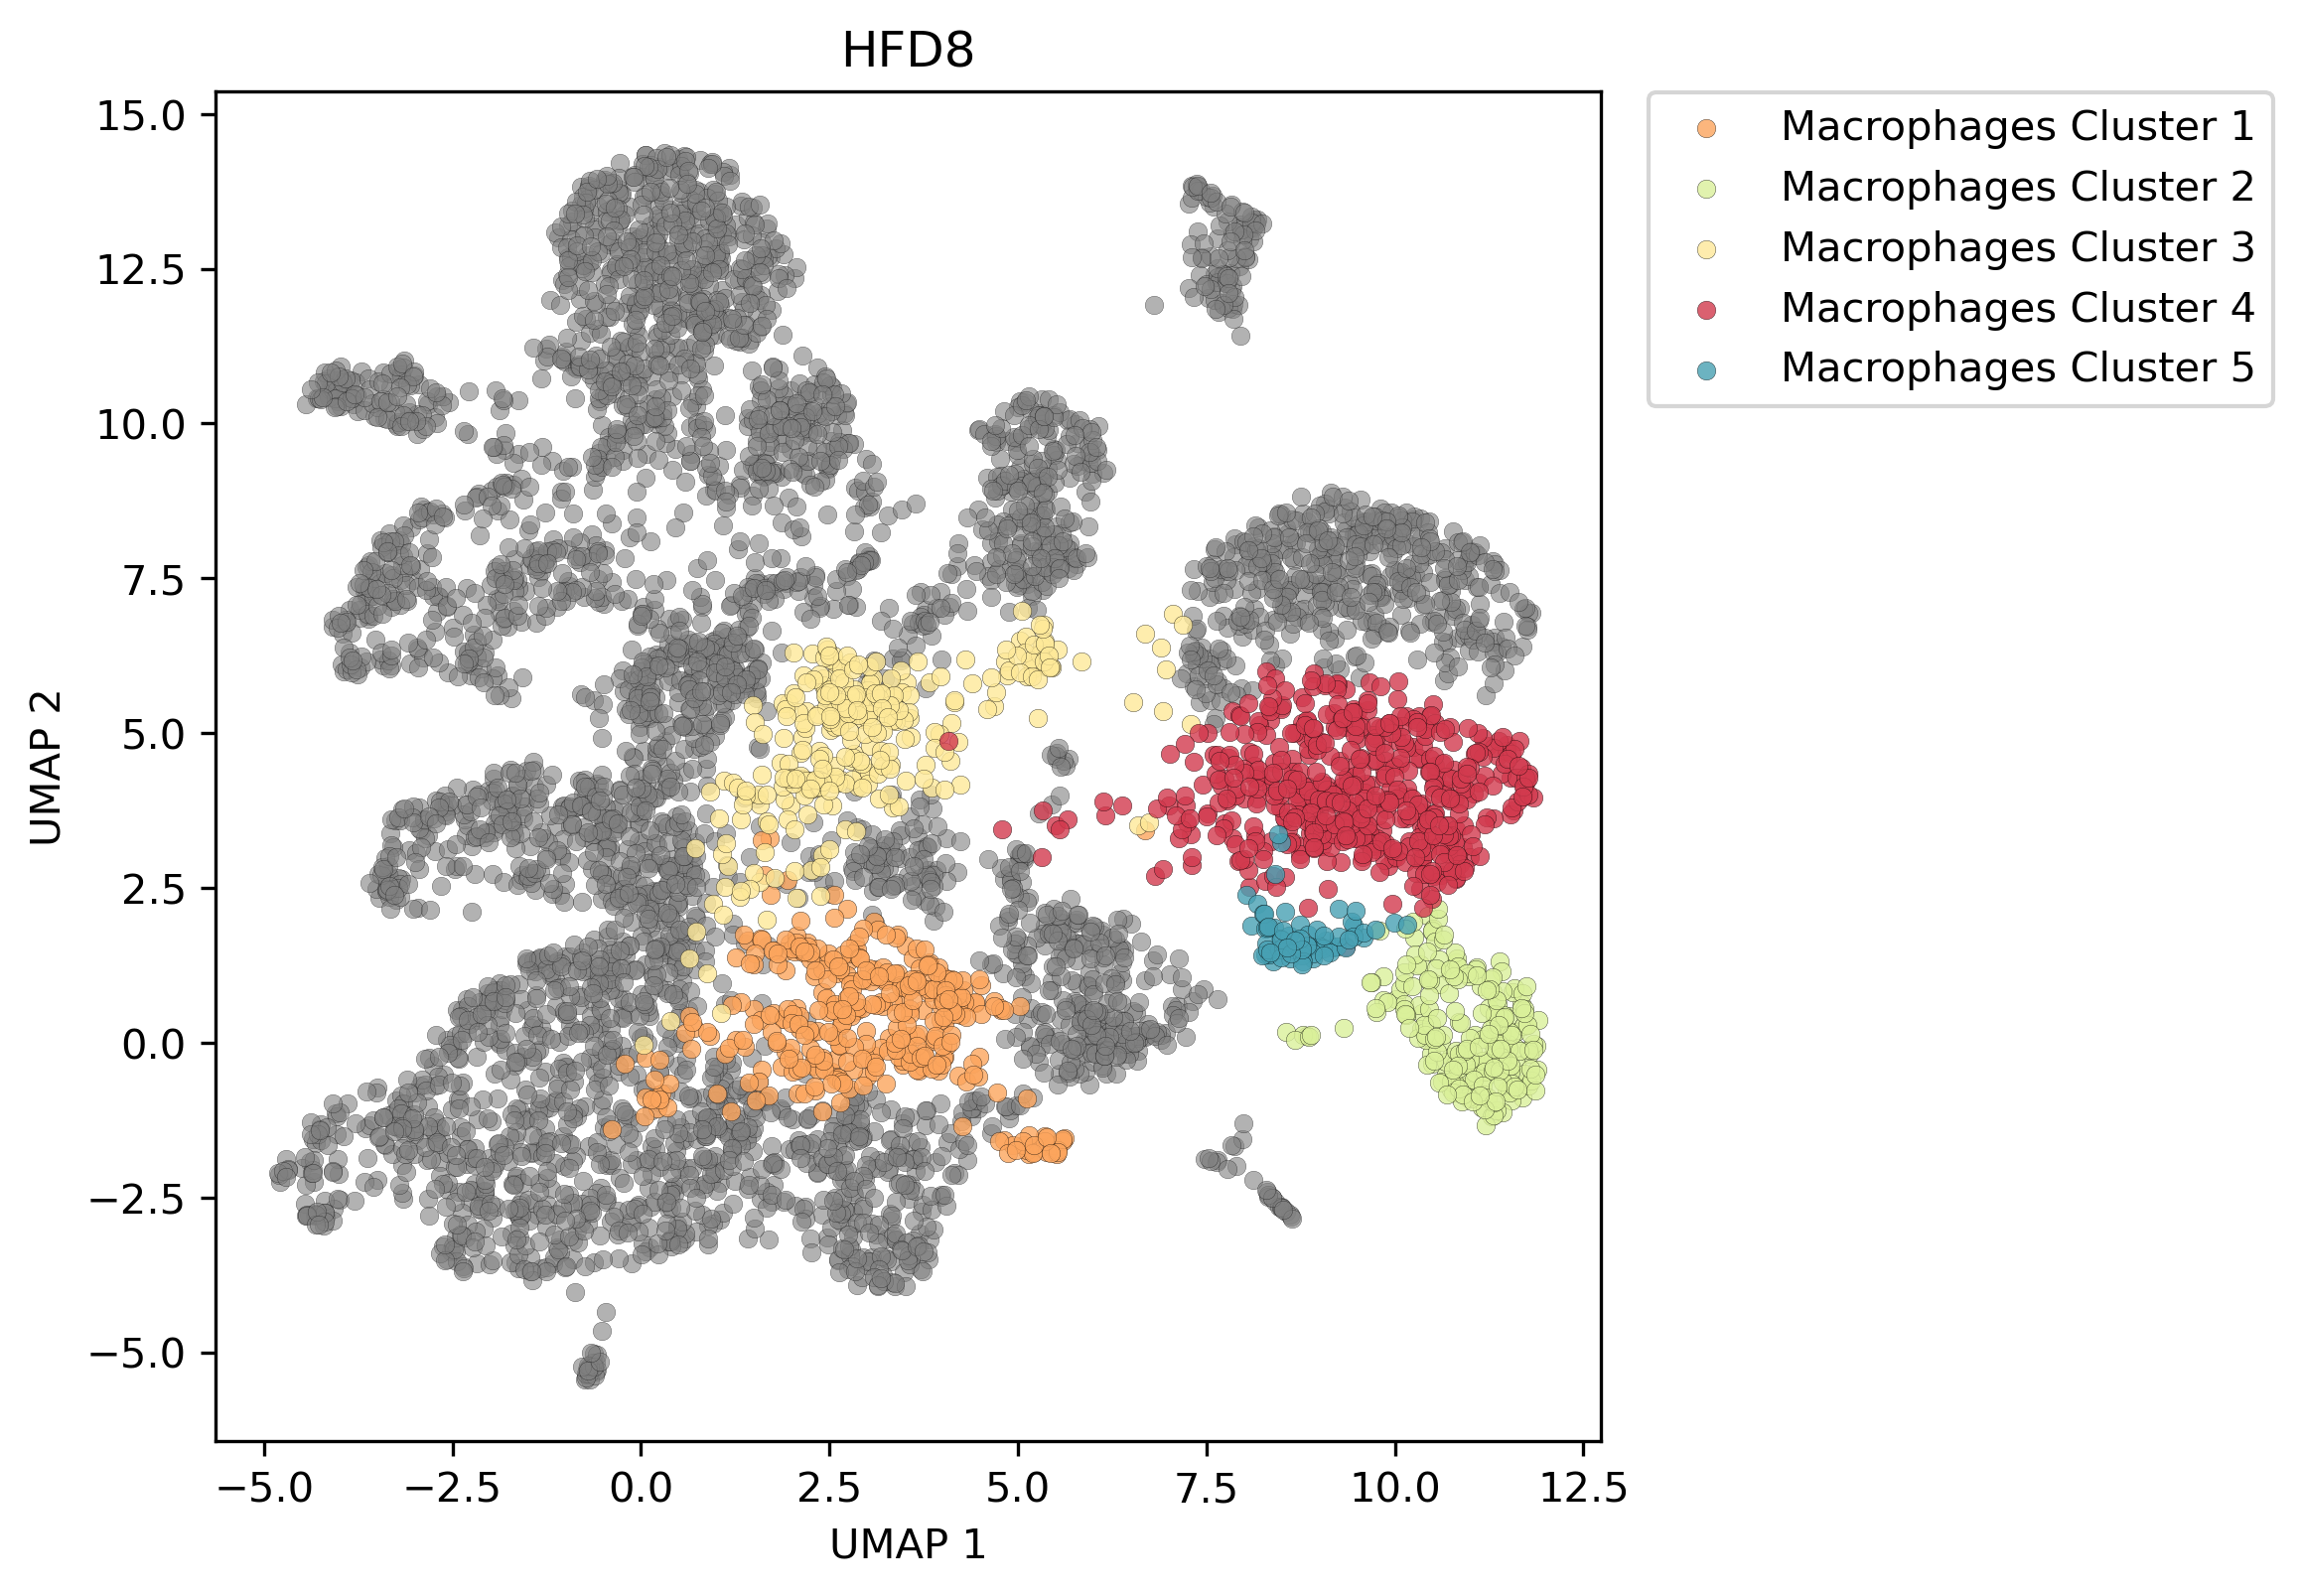

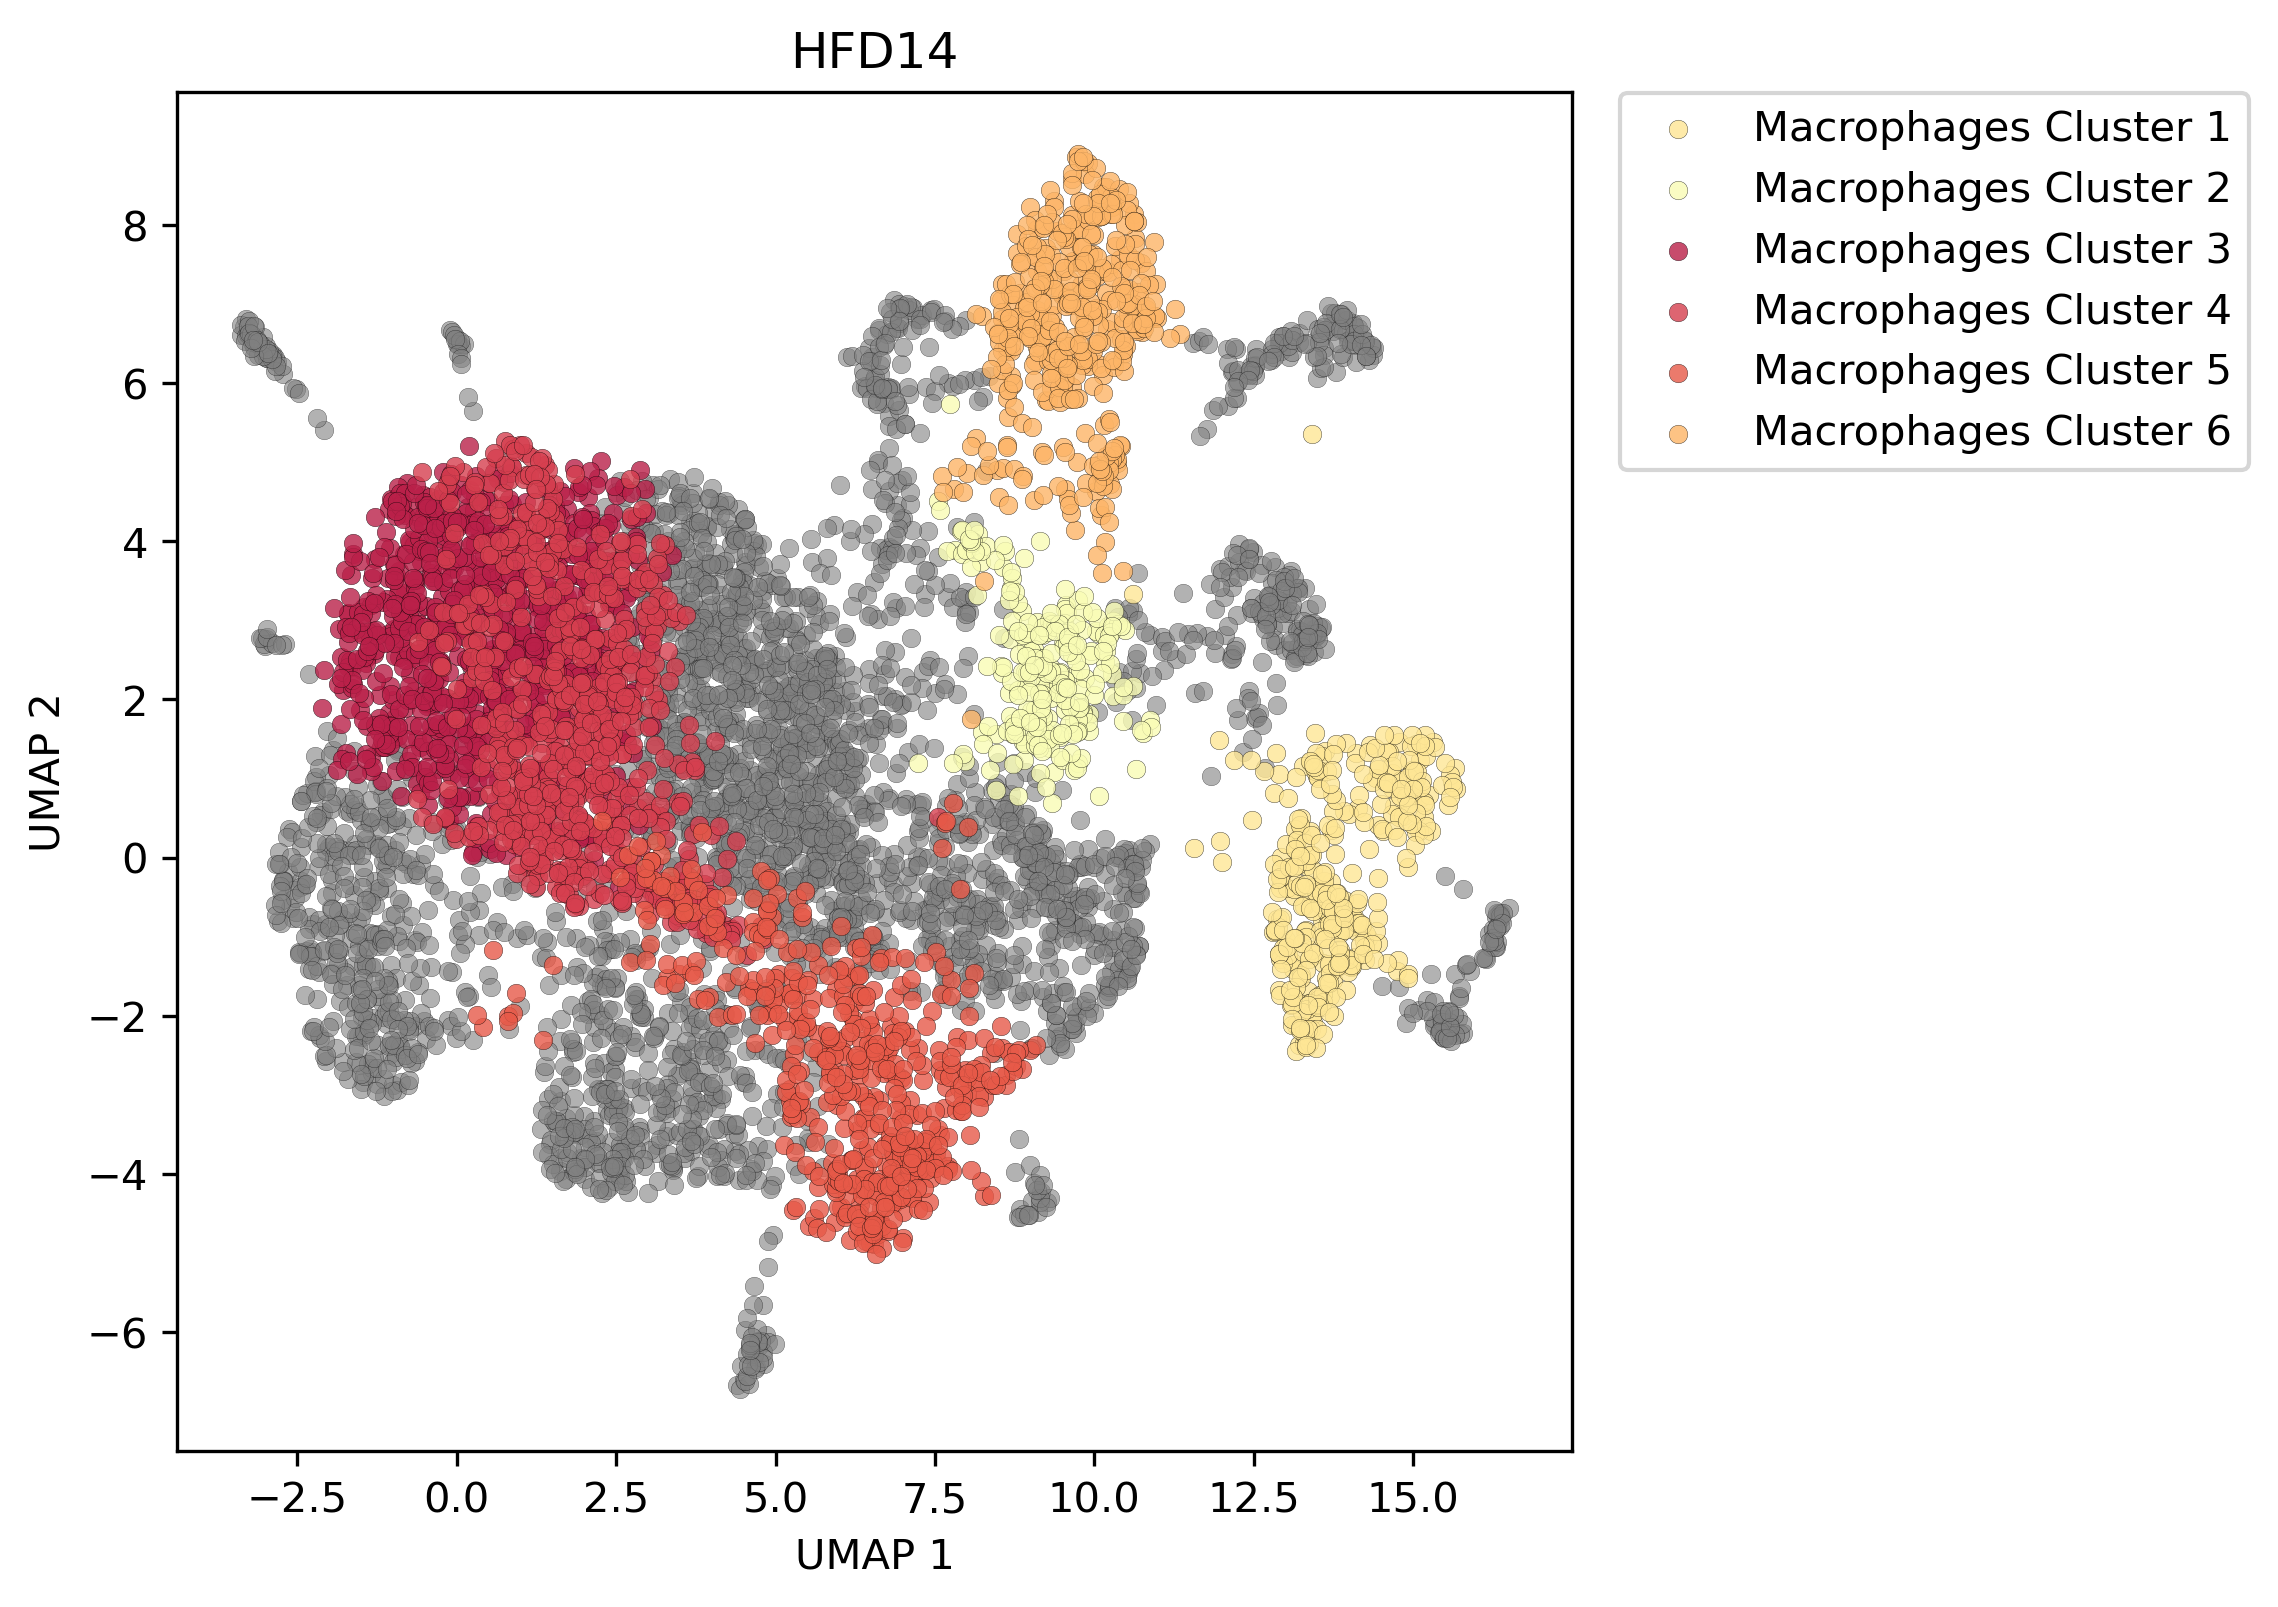

In [5]:
cellType = 'Macrophages'
runKey = "nn15_pca30_r0.75"

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 6
keys = ['ND', 'HFD8', 'HFD14']

for key in keys:
    data = adata[key]
    
    clusterIds = data.obs[runKey].astype(int)    
    # get number of clusterss
    k = data.obs[runKey].nunique() + 1
    colorlist = ut.ncolor(k, cmap='Spectral')
    
    # get all clusters for the cell type
    cellTypes = cid[key]
    cellTypeIds = cellTypes[cellTypes['cellType'] == cellType]['clusterId'].to_numpy()
    
    
    # get 2d coordinates
    embedding = data.obsm['X_umap']
    
    """
    PLOT background
    """
    cellInd = clusterIds.isin(cellTypeIds)

    plt.scatter(embedding[~cellInd, 0],
                embedding[~cellInd, 1],
                c='grey',
                edgecolor="k",
                linewidth=0.1,
                s=20,
                alpha=0.6)
    
    for i, ctid in enumerate(cellTypeIds):
        cellInd = (clusterIds == ctid)
        
        label = f"{cellType} Cluster {i+1}"
        
        plt.scatter(embedding[cellInd, 0],
                    embedding[cellInd, 1],
                    c=colorlist[ctid],
                    edgecolor="k",
                    linewidth=0.1,
                    s=20,
                    alpha=0.8,
                    label=label)

    plt.title(key)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.legend(bbox_to_anchor=(1.5, 1.015))
    plt.show()
    

# GO Enrichment Analysis

In [6]:

keys = ['ND', 'HFD8', 'HFD14']
topNgenes = 300

resList = {}

output = f"/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/scanpy/{cellType}.xlsx"
with pd.ExcelWriter(output) as writer:  
    for key in keys:
        print(f"working {key}")
        data = adata[key]
        df = data.to_df()
        result = data.uns['rank_genes_groups']
        keys = data.uns['rank_genes_groups'].keys()
        groups = result['names'].dtype.names

        clusterIds = data.obs[runKey].astype(int)
        cellTypes = cid[key]

        # get all clusters for the cell type
        cellTypeIds = cellTypes[cellTypes['cellType'] == cellType]['clusterId'].to_numpy()

        for ctid in cellTypeIds:
            genes = list(result['names'][str(ctid-1)])
            
            genes = genes[:topNgenes] # need to filter the top n genes
            
            gf = pd.Series(genes, name=f'top_{topNgenes}_genes') 
            sheetName = f"{key}_c_{ctid}_genes"
            gf.to_excel(writer, sheet_name=sheetName, index=False)
            
            sheetName = f"{key}_c_{ctid}_kegg"
            kegg = gget.enrichr(genes, database="KEGG_2019_Mouse")
            kegg.to_excel(writer, sheet_name=sheetName, index=False)
            
            sheetName = f"{key}_c_{ctid}_GO"
            onto = gget.enrichr(genes, database="ontology")
            onto.to_excel(writer, sheet_name=sheetName, index=False)
        
    
print("done")

Tue Nov  8 09:43:04 2022 INFO Performing Enichr analysis using database KEGG_2019_Mouse.


working ND


Tue Nov  8 09:43:04 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Tue Nov  8 09:43:05 2022 INFO Performing Enichr analysis using database KEGG_2019_Mouse.
Tue Nov  8 09:43:06 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Tue Nov  8 09:43:07 2022 INFO Performing Enichr analysis using database KEGG_2019_Mouse.


working HFD8


Tue Nov  8 09:43:07 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Tue Nov  8 09:43:08 2022 INFO Performing Enichr analysis using database KEGG_2019_Mouse.
Tue Nov  8 09:43:09 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Tue Nov  8 09:43:10 2022 INFO Performing Enichr analysis using database KEGG_2019_Mouse.
Tue Nov  8 09:43:10 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of

working HFD14


Tue Nov  8 09:43:15 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Tue Nov  8 09:43:16 2022 INFO Performing Enichr analysis using database KEGG_2019_Mouse.
Tue Nov  8 09:43:16 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Tue Nov  8 09:43:17 2022 INFO Performing Enichr analysis using database KEGG_2019_Mouse.
Tue Nov  8 09:43:18 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of

done
